In [2]:
df1 = pd.read_excel('../dataset/bank_data.xlsx')
df2 = pd.read_excel('../dataset/cibil_data.xlsx')

In [3]:
# extensive data of the customers 
df = pd.merge(df1, df2, 'inner', on='PROSPECTID')

In [4]:
# saving dataframe with pickle, faster upload
df.to_pickle('../artifacts/full_data.pkl')
df.to_csv('../artifacts/full_data.csv', index=False)

In [5]:
df = pd.read_pickle('../artifacts/full_data.pkl')

The -99999 are used for null value, and should be rectified

In [6]:
# impute -99999 with null
df.replace(-99999, np.nan, inplace=True)

In [7]:
# null_col: column with null values
null_col = df.isna().sum()[lambda x: x > 0].index
df[null_col].isna().sum().sort_values()

Age_Oldest_TL                      40
Age_Newest_TL                      40
pct_currentBal_all_TL              72
time_since_recent_payment        4291
enq_L3m                          6321
enq_L6m                          6321
enq_L12m                         6321
time_since_recent_enq            6321
PL_enq_L12m                      6321
PL_enq_L6m                       6321
PL_enq                           6321
CC_enq_L12m                      6321
CC_enq_L6m                       6321
CC_enq                           6321
tot_enq                          6321
max_deliq_12mts                 10832
max_deliq_6mts                  12890
max_unsec_exposure_inPct        23178
max_delinquency_level           35949
time_since_recent_deliquency    35949
time_since_first_deliquency     35949
PL_utilization                  44435
CC_utilization                  47636
dtype: int64

* PL_utilization and CC_utilization are only features associated with utilization of TL, and cannot be imputed with confidence.This features needs to be dropped.
* time_since_first_deliquency, time_since_recent_deliquency, and max_delinquency_level are related to customer default/deliquency. There are many more features related to deliquency, require further analysis before making any decision.
* max_unsec_exposure_inPct have 2 related features (Secured_TL, Unsecured_TL) which does not show any direction correlation with `maximum %(exposure to unsecured TL)`. This column cannot be immputed and should be dropped.
* max_deliq_6mts, and max_deliq_12mts are similar to point 2, about default/deliquency. 
* Alot of features have 6321 null values (-99999). 
* `time_since_recent_payment` also need further analysis, however there is no feature to interpret these missing values.

In [8]:
### Dropping null age and balance entries
df.dropna(subset=['Age_Oldest_TL', 'Age_Newest_TL', 'pct_currentBal_all_TL'], inplace=True)

# dropping utilization features.
df.drop(['PL_utilization', 'CC_utilization', 'max_unsec_exposure_inPct'], axis=1, inplace=True)

### Analysis for deliquency features

In [9]:
# delinquency features with more than 50% null values

null_deq_col = ['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level']
rest_deq_col = ['num_times_delinquent', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'recent_level_of_deliq']

df[null_deq_col].isna().sum(axis=1).value_counts()

3    35845
0    15381
dtype: int64

In [10]:
# check for any deq in customer history
df.num_times_delinquent[df[null_deq_col].isna().sum(axis=1) == 3].value_counts()

0    35845
Name: num_times_delinquent, dtype: int64

In [12]:
# cross verify / double check
df.max_delinquency_level[df['num_times_delinquent'] == 0].isna().sum()

35845

In [13]:
# fill null deq with 0
df[null_deq_col] = df[null_deq_col].fillna(0)

In [14]:
other_null_deq_index = df[['max_deliq_12mts', 'max_deliq_6mts']].isna().sum(axis=1)
other_null_deq_index.value_counts()

0    38428
2    10741
1     2057
dtype: int64

In [15]:
df.loc[other_null_deq_index > 0]['num_times_delinquent']

0        11
3         0
4         0
6         0
9         0
         ..
51322     0
51327     1
51328     0
51329     0
51335     0
Name: num_times_delinquent, Length: 12798, dtype: int64

In [16]:
# impute 0 for other null deq if num of deq is 0
other_null_deq_col = ['max_deliq_6mts', 'max_deliq_12mts']
other_null_no_deq_index = df[df.num_times_delinquent == 0].index

df.loc[other_null_no_deq_index, other_null_deq_col] = df.loc[other_null_no_deq_index, other_null_deq_col].fillna(0)


In [17]:
# remaining null deq
df[other_null_deq_col].isna().sum()

max_deliq_6mts     2612
max_deliq_12mts    1677
dtype: int64

In [18]:
reamining_null_deq_series = df[other_null_deq_col].isna().sum(axis=1)
reamining_null_deq_series.value_counts()

0    48614
2     1677
1      935
dtype: int64

In [19]:
df[other_null_deq_col].isna().sum(axis=0)

max_deliq_6mts     2612
max_deliq_12mts    1677
dtype: int64

In [20]:
df[reamining_null_deq_series >= 1]

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,Total_TL_opened_L12M,Tot_TL_closed_L12M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,Auto_TL,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_30p_dpd,num_times_60p_dpd,num_std,num_std_6mts,num_std_12mts,num_sub,num_sub_6mts,num_sub_12mts,num_dbt,num_dbt_6mts,num_dbt_12mts,num_lss,num_lss_6mts,num_lss_12mts,recent_level_of_deliq,tot_enq,CC_enq,CC_enq_L6m,CC_enq_L12m,PL_enq,PL_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L12m,enq_L6m,enq_L3m,MARITALSTATUS,EDUCATION,AGE,GENDER,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,5,4,1,0,0,0.000,0.000,0.200,0.800,0,0,0.000,0.000,0,0,0,0,1,0,4,1,4,0,72.0,18.0,549.0,35.0,15.0,11,29.0,29,0,0,0,NaN,NaN,0,0,21,5,11,0,0,0,0,0,0,0,0,0,29,6.0,0.0,0.0,0.0,6.0,0.0,0.0,566.0,0.0,0.0,0.0,Married,12TH,48,M,51000,114,0.200,0.0,0.798,0,1,0.0,0.0,0.0,0.0,1,0,PL,PL,696,P2
12,13,2,2,0,0,0,0.000,0.000,0.000,1.000,0,0,0.000,0.000,0,1,0,0,0,0,0,2,0,1,49.0,49.0,1037.0,24.0,24.0,1,31.0,31,0,0,0,NaN,NaN,1,0,33,4,10,0,0,0,0,0,0,0,0,0,31,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,Married,SSC,30,M,55000,126,0.000,0.0,0.000,0,0,0.0,0.0,0.0,0.0,0,0,ConsumerLoan,others,669,P2
19,20,7,5,2,1,0,0.143,0.000,0.286,0.714,1,1,0.143,0.143,0,0,0,0,2,0,0,5,2,5,138.0,3.0,80.0,30.0,11.0,8,89.0,89,0,1,1,NaN,22.0,2,1,38,6,12,0,0,0,0,0,0,0,0,0,22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1679.0,0.0,0.0,0.0,Married,UNDER GRADUATE,31,M,48000,126,0.286,1.0,0.539,0,0,0.0,0.0,0.0,0.0,1,0,others,others,720,P1
26,27,1,1,0,0,0,0.000,0.000,0.000,1.000,0,0,0.000,0.000,0,0,1,0,0,0,0,0,1,0,59.0,59.0,1341.0,35.0,10.0,10,190.0,190,0,2,2,NaN,190.0,9,8,0,0,0,0,0,0,0,0,0,0,0,0,190,3.0,2.0,1.0,1.0,0.0,0.0,0.0,58.0,1.0,1.0,1.0,Single,12TH,28,M,20000,39,0.000,0.0,0.000,1,0,0.0,1.0,0.0,0.5,0,0,CC,others,660,P3
28,29,42,34,8,2,2,0.048,0.048,0.190,0.810,5,3,0.119,0.071,3,0,0,0,26,1,0,35,7,15,159.0,4.0,88.0,34.0,34.0,1,183.0,183,0,0,0,NaN,0.0,1,1,107,17,43,0,0,0,0,0,0,0,0,0,183,1.0,0.0,0.0,0.0,0.0,0.0,0.0,366.0,0.0,0.0,0.0,Married,SSC,37,F,25000,101,0.190,0.4,0.979,0,0,0.0,0.0,0.0,0.0,1,1,HL,HL,740,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51188,51189,1,1,0,0,0,0.000,0.000,0.000,1.000,0,0,0.000,0.000,0,1,0,0,0,0,0,1,0,0,90.0,90.0,NaN,23.0,23.0,1,120.0,120,0,0,0,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Married,SSC,39,M,17000,95,0.000,0.0,0.000,0,0,0.0,0.0,0.0,0.0,0,0,others,others,671,P2
51203,51204,22,11,11,0,0,0.000,0.000,0.500,0.500,7,2,0.318,0.091,11,1,0,2,10,0,1,19,3,8,56.0,7.0,NaN,14.0,14.0,1,1.0,1,0,0,0,NaN,NaN,0,0,110,20,48,0,0,0,0,0,0,0,0,0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,814.0,0.0,0.0,0.0,Married,12TH,32,F,12000,74,0.500,0.0,0.950,0,1,0.0,0.0,0.0,0.0,1,0,HL,AL,716,P1
51258,51259,4,4,0,0,1,0.000,0.250,0.000,1.000,0,1,0.000,0.250,0,0,0,1,1,0,0,3,1,2,80.0,14.0,178.0,13.0,10.0,3,42.0,12,0,1,1,NaN,12.0,1,0,11,0,0,0,0,0,0,0,0,0,0,0,12,7.0,0.0,0.0,0.0,1.0,0.0,1.0,34.0,5.0,3.0,2.0,Married,GRADUATE,35,F,22000,170,0.000,0.0,0.000,0,0,0.0,0.0,0.0,0.0,1,0,ConsumerLoan,ConsumerLoan,667,P3
51310,51311,3,1,2,0,0,0.000,0.000,0.667,0.333,0,0,0.000,0.000,

Remaining null in deq features could not be imputed with confidence, as no colums related to delinquency level and needs to be rejected from dataset.

In [21]:
#df = df.drop(['max_deliq_6mts', 'max_deliq_12mts'], axis=1)

### Analysis of enquiry features

In [22]:
null_col = df.isna().sum(axis=0)[lambda x: x>0].index
df[null_col].isna().sum(axis=0).sort_values()

max_deliq_12mts              1677
max_deliq_6mts               2612
time_since_recent_payment    4248
tot_enq                      6277
CC_enq                       6277
CC_enq_L6m                   6277
CC_enq_L12m                  6277
PL_enq                       6277
PL_enq_L6m                   6277
PL_enq_L12m                  6277
time_since_recent_enq        6277
enq_L12m                     6277
enq_L6m                      6277
enq_L3m                      6277
dtype: int64

In [23]:
# null enq columns which have NAN for 6321 customers.
null_enq_col = ['tot_enq', 'CC_enq', 'CC_enq_L6m', 'enq_L3m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'CC_enq_L12m']
df[null_enq_col].isna().sum(axis=1).value_counts()

0     44949
11     6277
dtype: int64

6321 customer are about 12% of the dataset and have 11 missing entries (related to enq) per customer. These customer record needs to be removed since there is no other variable to impute data with confidence.

Dropping customer record to save enquire data is a viable and better approach as dropping features would result in no absolute enquire related feature.

In [24]:
# picked any enq feature as there's no sparsity in missing values of enq features.
df.dropna(subset=['tot_enq'], inplace=True)
df.shape

(44949, 84)

### Analysing remaining features with NULL

In [25]:
null_col = df.isna().sum(axis=0)[lambda x: x>0].index
df[null_col].isna().sum(axis=0).sort_values()

max_deliq_12mts              1258
max_deliq_6mts               2021
time_since_recent_payment    2885
dtype: int64

In [26]:
df.isna().sum(axis=1).value_counts()

0    40192
1     3440
2     1227
3       90
dtype: int64

To save a feature, atleast 90 customer records will be dropped. There is no reason specifically to keep a feature, we can compare the model perform before and after removing remanining feature.

In [27]:
# no of customer with 1 null in their record
temp = df[df.isna().sum(axis=1) == 2]
temp_col = temp.loc[:, temp.isna().any()].columns
temp[temp_col].isna().sum()

time_since_recent_payment      59
max_deliq_6mts               1227
max_deliq_12mts              1168
dtype: int64

In [28]:
# no of customer with 1 null in their record
temp = df[df.isna().sum(axis=1) == 1]
temp_col = temp.loc[:, temp.isna().any()].columns
temp[temp_col].isna().sum()

time_since_recent_payment    2736
max_deliq_6mts                704
dtype: int64

In [63]:
# dropping all customer record for multi-collinearity check
no_null_a1 = df.dropna(subset=['time_since_recent_payment', 'max_deliq_6mts', 'max_deliq_12mts'])
no_null_a2 = df.dropna(subset=['time_since_recent_payment']).drop(['max_deliq_6mts', 'max_deliq_12mts'], axis=1)

In [31]:
(no_null_a1.dtypes != object).sum()

78

In [42]:
numeric = no_null_a1.select_dtypes(exclude='object').columns.drop(['PROSPECTID'])
categoric = no_null_a1.select_dtypes(include='object').columns.drop(['Approved_Flag'])

col_keep = []
    
for i in numeric:
    x = list(no_null_a1[i]) 
    y = list(no_null_a1['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(x, y) if group == 'P1']
    group_P2 = [value for value, group in zip(x, y) if group == 'P2']
    group_P3 = [value for value, group in zip(x, y) if group == 'P3']
    group_P4 = [value for value, group in zip(x, y) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        col_keep.append(i)
        
for i in categoric:
    chi2, p_value, _, _ = chi2_contingency(pd.crosstab(no_null_a1[i], no_null_a1['Approved_Flag']))
    
    if p_value <= 0.05:
        col_keep.append(i)
        
col_keep.append('PROSPECTID')
col_keep.append('Approved_Flag')
no_null_a1 = no_null_a1[col_keep]

In [64]:
# VIF measure for multi-collinearity
numeric_col = no_null_a1.select_dtypes(exclude=object).columns.drop(['PROSPECTID'])
vif_values = pd.DataFrame(numeric_col, columns=['feature'])
vif_values['vif'] = [variance_inflation_factor(no_null_a1[numeric_col].values, i) for i in range(numeric_col.size)]
vif_values = vif_values[vif_values['vif'] < np.inf]
vif_values.sort_values('vif', inplace=True)
vif_values

,feature,vif
67,pct_currentBal_all_TL,1.000725
63,NETMONTHLYINCOME,1.054771
64,Time_With_Curr_Empr,1.268358
62,AGE,1.410414
41,num_sub,1.492989
74,HL_Flag,1.788550
47,num_lss,1.788822
58,time_since_recent_enq,1.794991
42,num_sub_6mts,2.098814
69,PL_Flag,2.317569


In [66]:
low_vif_col = vif_values[vif_values['vif'] <= 5]
high_vif_col = vif_values[vif_values['vif'] > 5].drop(index=8)
print(low_vif_col.shape[0], high_vif_col.shape[0])

23 36


Considering that credit score is govern basis of various parameters from customer credit record, the high `vif` score of 11.98 that it is not an independent variable. 

Better to pick feature with better `vif`` score.

In [69]:
low_vif_col

,feature,vif
67,pct_currentBal_all_TL,1.000725
63,NETMONTHLYINCOME,1.054771
64,Time_With_Curr_Empr,1.268358
62,AGE,1.410414
41,num_sub,1.492989
74,HL_Flag,1.788550
47,num_lss,1.788822
58,time_since_recent_enq,1.794991
42,num_sub_6mts,2.098814
69,PL_Flag,2.317569


Basis of the limited domain knowledge and feature present in low_vif_col, the highlighted feature appears relevant for modeling:

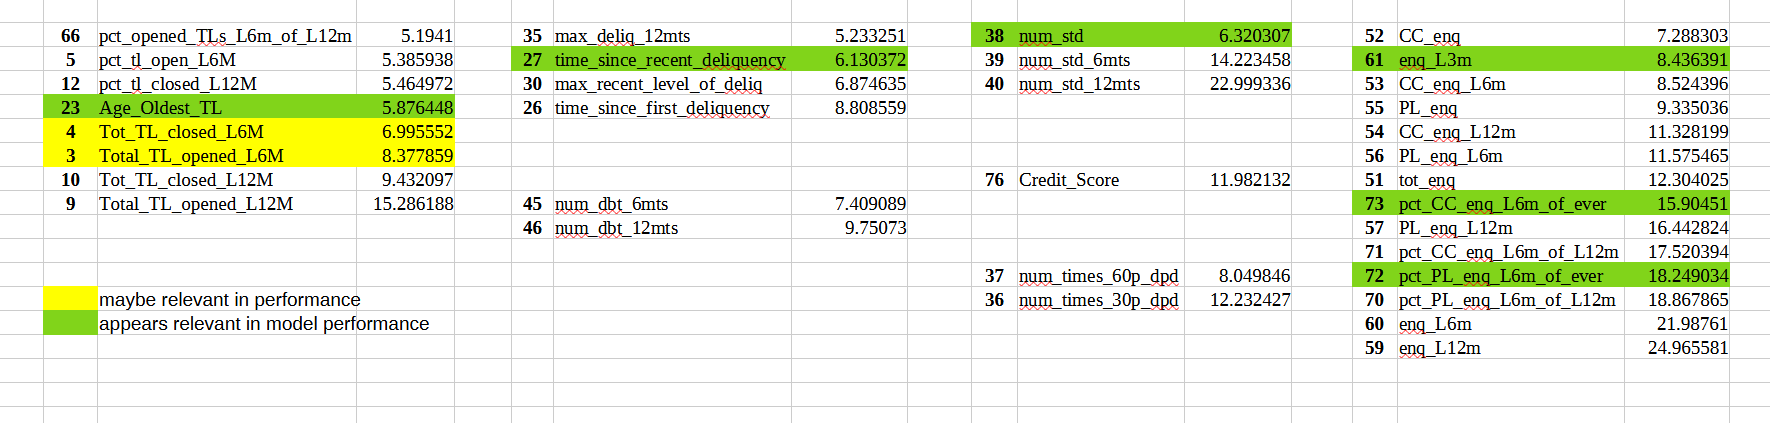

In [71]:
X, y = no_null_a1.drop('Approved_Flag', axis=1), no_null_a1[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

ValueError: could not convert string to float: 'Single'

decision_tree